In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import os
import json

In [2]:
def show_images(images, plotter=None):
    def do_plot(arg, sp):
        if isinstance(plotter, str):
            img = arg[plotter]
        elif plotter is not None:
            img = plotter(arg, sp)
            if img is None:
                return
        else:
            img = arg
        sp.imshow(img, cmap='gray')
        
    fig = plt.figure(figsize=(20, 15))
    subplots = [p for row in fig.subplots(2, 3) for p in row]
    for i, sp in enumerate(subplots):
        do_plot(images[i], sp)
    plt.tight_layout()
    plt.show()


def to_rgb(img):
    assert len(img.shape) == 2
    colored = np.zeros(img.shape + (3,), dtype=np.uint8)
    colored[:, :, 0] = colored[:, :, 1] = colored[:, :, 2] = img
    return colored

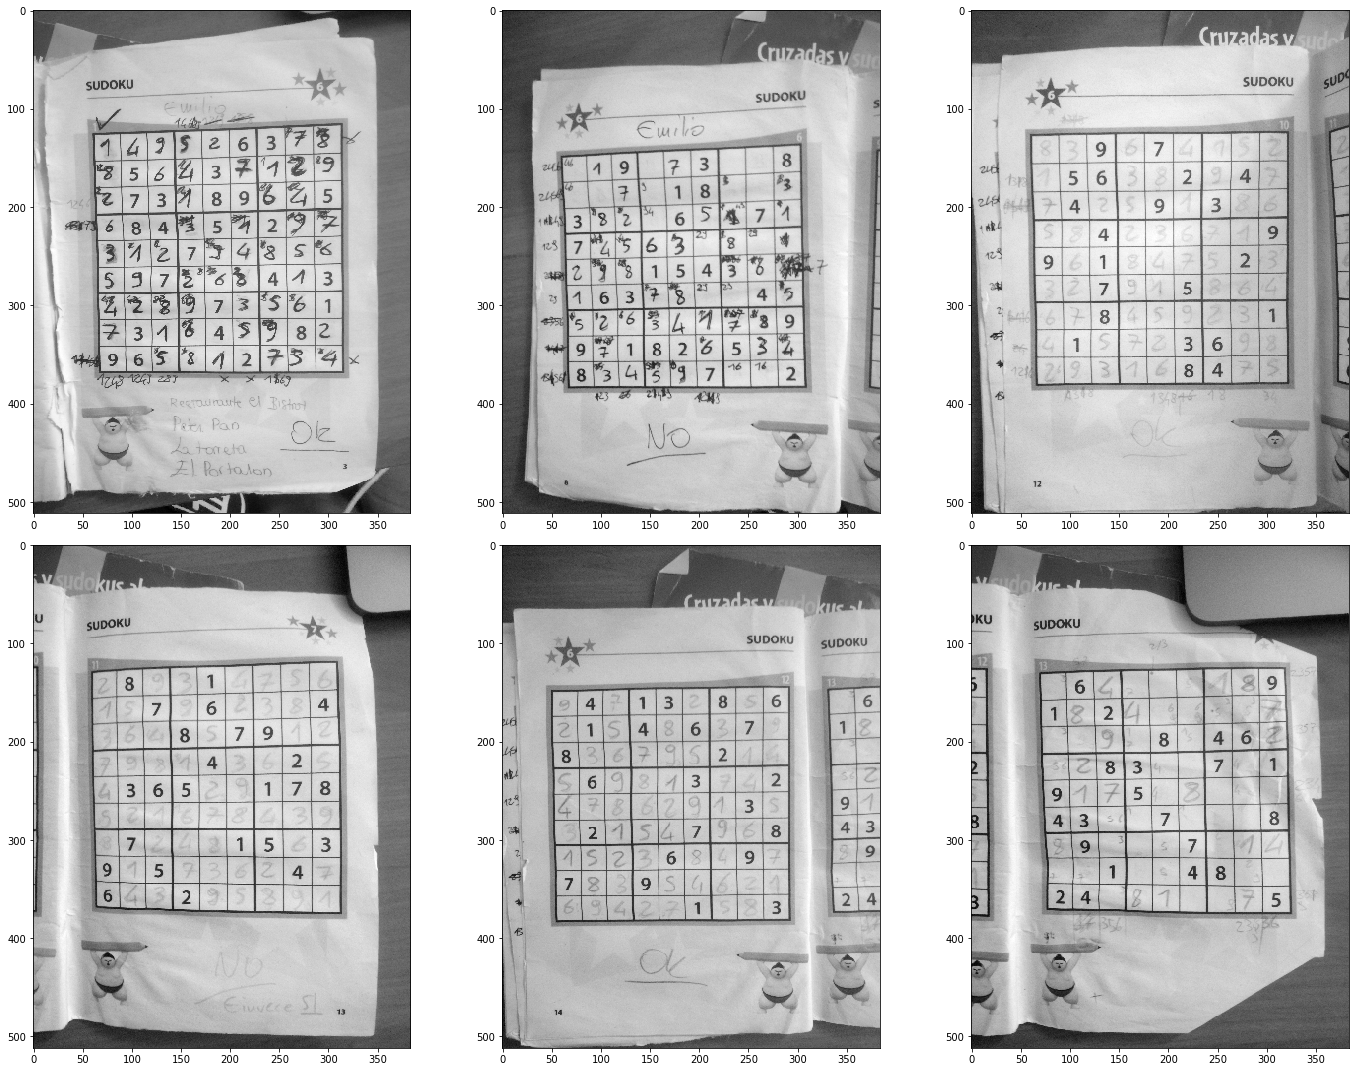

In [3]:
def load_image(img):
    if isinstance(img, str):
        image = cv2.imread(img)
    elif isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            raise ValueError('img must be an uint8 array')
        elif len(img.shape) != 3:
            raise ValueError('img must be a 3-dimensional array (channel last)')
        else:
            image = img
    else:
        raise ValueError('argument must be path to image or numpy array')
    
    rows, cols, _ = image.shape
    if abs(cols / rows - 0.75) > 0.01 and abs(rows / cols - 0.75) > 0.01:
        print('WARN works best with aspect ratio 3:4')
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    dsize = (768, 1024) if cols < rows else (1024, 768)
    dsize = (384, 512) if cols < rows else (512, 384)
    image = cv2.resize(image, dsize)
    return {
        'img': image,
        'orig': img,
    }

images_dir = './images/'
images = [load_image(images_dir + fname) for fname in os.listdir(images_dir)]
show_images(images, 'img')

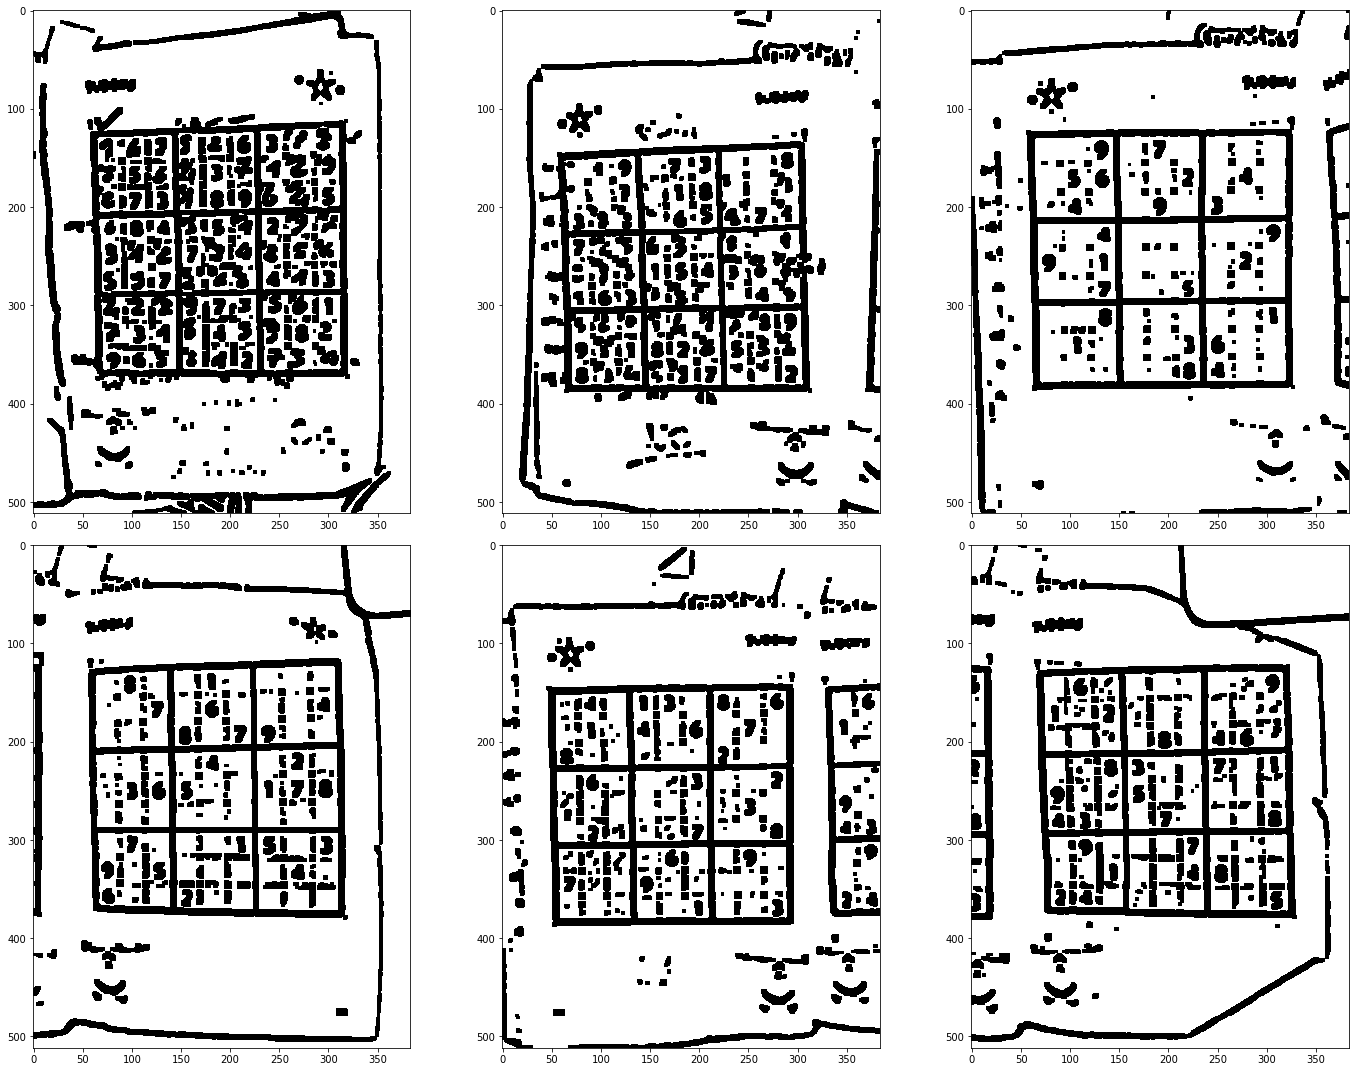

In [4]:
def threshold_img(arg):
    img = arg['img']
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    #img = clahe.apply(img)
    img = cv2.GaussianBlur(img, (5, 5), 5)
    #img = cv2.equalizeHist(img)
    #img = cv2.bilateralFilter(img, d=15, sigmaColor=15, sigmaSpace=15)
    #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7)
    #img = cv2.dilate(img, np.ones((2, 2), dtype=np.uint8), iterations=1)
    img = cv2.erode(img, np.ones((4, 4), dtype=np.uint8), iterations=1)
    arg['bin'] = img
    return arg

images_binary = list(map(threshold_img, images))
show_images(images_binary, 'bin')

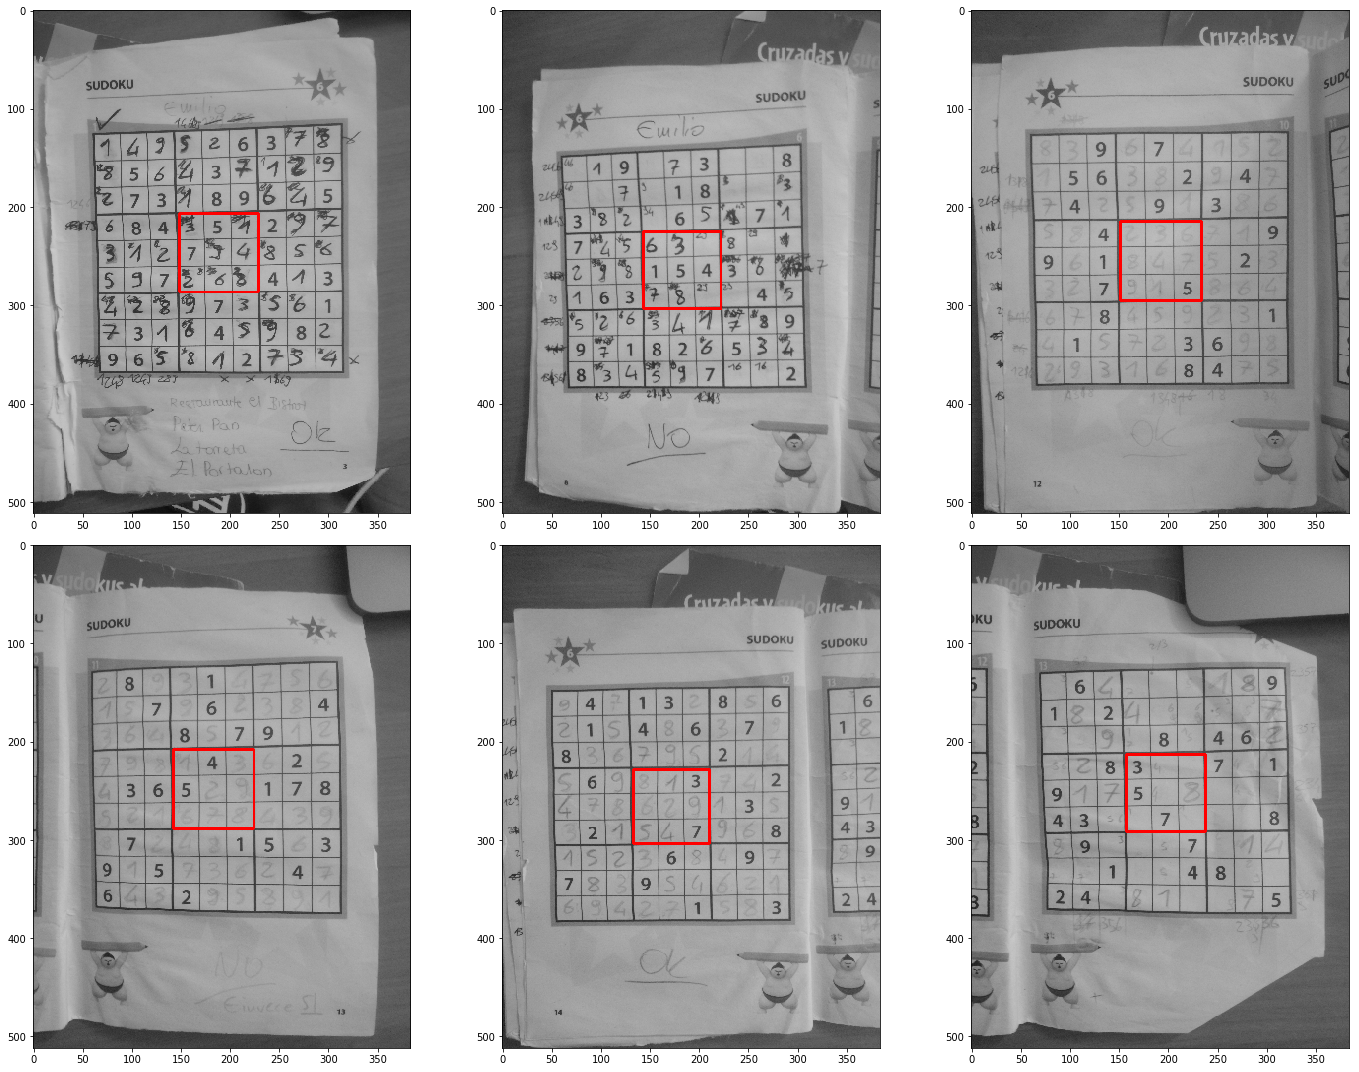

In [5]:
def find_square_by_fill(img, ax, ay, bx, by, patch_size_f):
    '''
    find a sodoku square by flood filling
    filling starts from within 100 * patch_size_f percent of the rectangle
    enclosed by (ax, ay) and (bx, by)
    '''
    
    width, height = bx - ax, by - ay
    
    # create mask for floodfill
    mask = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=np.uint8)
    mask[1:img.shape[0]+1, 1:img.shape[1]+1] = 255 - img
    
    # seed will be chosen from within here
    patch_size = int(width * patch_size_f), int(height * patch_size_f)
    patch_topleft = (
        int(ax + width * (0.5 - patch_size_f / 2)),
        int(ay + height * (0.5 - patch_size_f / 2)),
    )
    
    i, filled = 0, False
    while i < 50:
        i += 1

        # choose a random seed
        seed_x = np.random.randint(patch_topleft[0], patch_topleft[0] + patch_size[0])
        seed_y = np.random.randint(patch_topleft[1], patch_topleft[1] + patch_size[1])

        # floodfill from there
        retval, image, mask, rect = cv2.floodFill(img.copy(), mask, (seed_x, seed_y), 100)
        
        if retval > 0:
            x, y, w, h = rect
            return x - 2, y - 2, x + w + 2, y + h + 2  # pad a bit to undo previous eroding

    # show debug info
    cc = to_rgb(mask)
    cv2.drawContours(cc, contours, -1, (0, 255, 0), 2)
    cv2.rectangle(cc, patch_topleft, (patch_topleft[0] + patch_size[0], patch_topleft[1] + patch_size[1]), (255, 0, 0), 2)
    cv2.circle(cc, seed, 4, (255, 0, 0), 2)
    plt.imshow(cc)
    plt.show()
    
    raise RuntimeError('could not find center square')


def find_center_3by3_square(arg):
    height, width = arg['bin'].shape
    center = find_square_by_fill(arg['bin'], 0, 0, width, height, 0.1)
    arg['center_3x3'] = center
    return arg


def plot_center_3by3(arg, sp):
    if arg['center_3x3'] is not None:
        colored = to_rgb(arg['img'])
        cv2.rectangle(colored, arg['center_3x3'][:2], arg['center_3x3'][2:], (255, 0, 0), 2)
        return colored


images_center_filled = list(map(find_center_3by3_square, images_binary))
show_images(images_center_filled, plot_center_3by3)

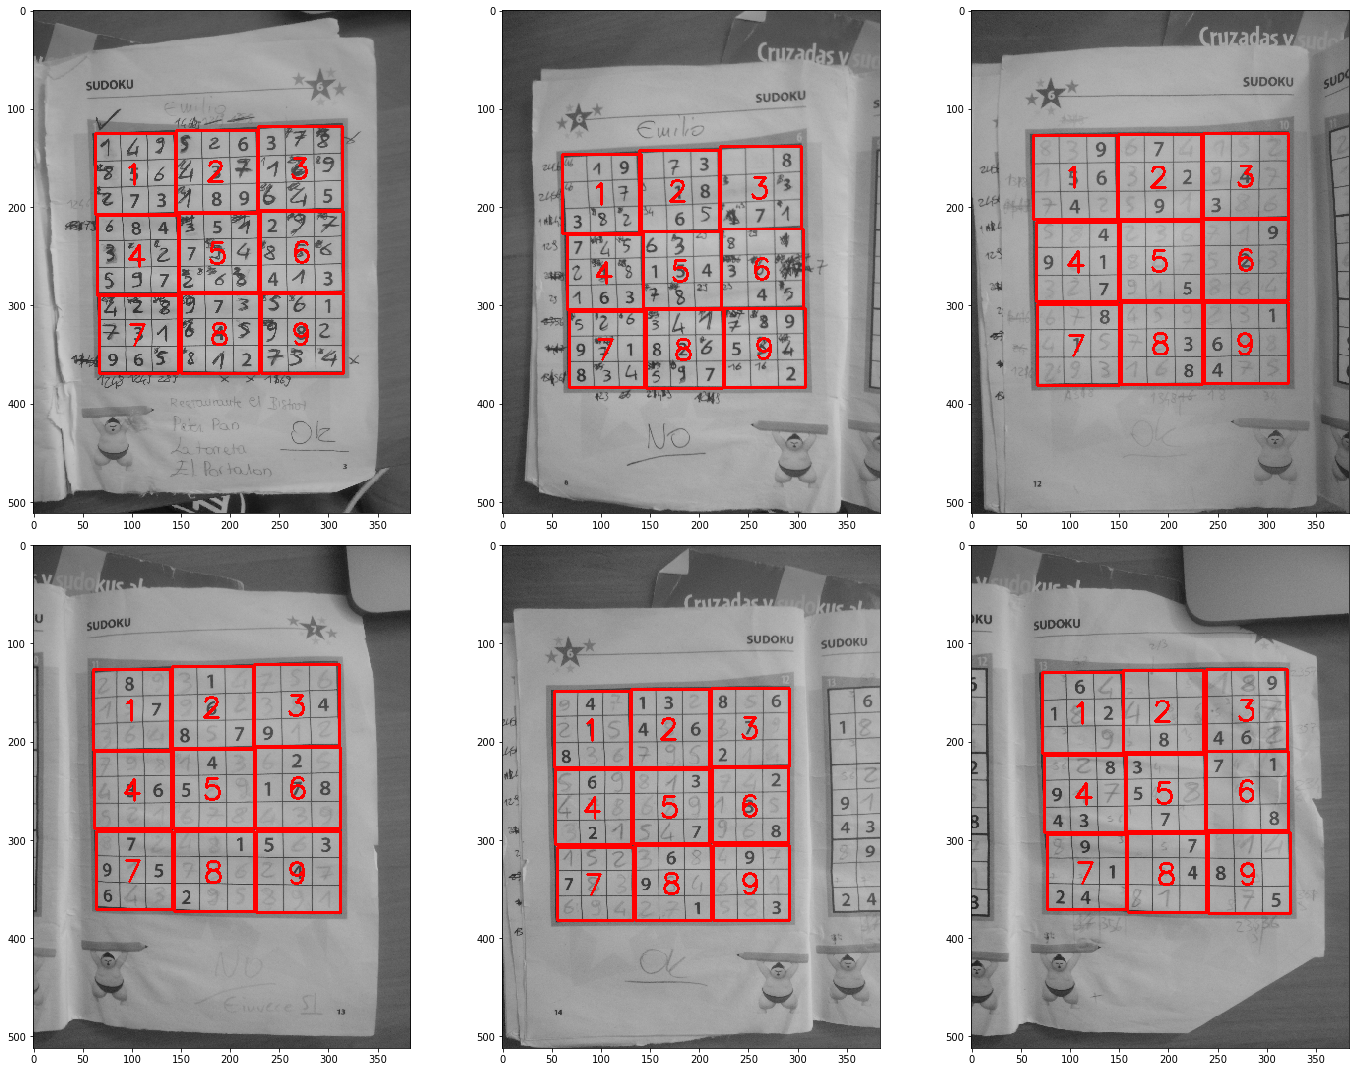

In [6]:
def find_all_squares(arg):
    multipliers = [
        (-1, -1), (0, -1), (1, -1),
        (-1, 0), (0, 0), (1, 0),
        (-1, 1), (0, 1), (1, 1)
    ]
    
    ax, ay, bx, by = arg['center_3x3']
    width, height = bx - ax, by - ay
    pad_x, pad_y = 0. * width, 0. * height
    
    arg['squares'] = []
    for m1, m2 in multipliers:
        px, py = ax + width * m1 - pad_x, ay + height * m2 - pad_y
        qx, qy = bx + width * m1 + pad_x, by + height * m2 + pad_y
        
        square = find_square_by_fill(arg['bin'], px, py, qx, qy, 0.5)
        arg['squares'].append(square)
    
    return arg


def plot_all_squares(arg, sp):
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (255, 0, 0)
    thickness = 2
    
    colored = to_rgb(arg['img'])
    for i, (ax, ay, bx, by) in enumerate(arg['squares']):
        text = str(i + 1)
        (text_width, text_height), _ = cv2.getTextSize(text, fontFace, fontScale, thickness)
        text_x = (ax + bx) / 2 - text_width / 2
        text_y = (ay + by) / 2 + text_height / 2
        cv2.putText(
            colored, text, (int(text_x), int(text_y)),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
        )

        cv2.rectangle(colored, (ax, ay), (bx, by), (255, 0, 0), 2)
    return colored


images_all_squares = list(map(find_all_squares, images_center_filled))
show_images(images_all_squares, plot_all_squares)

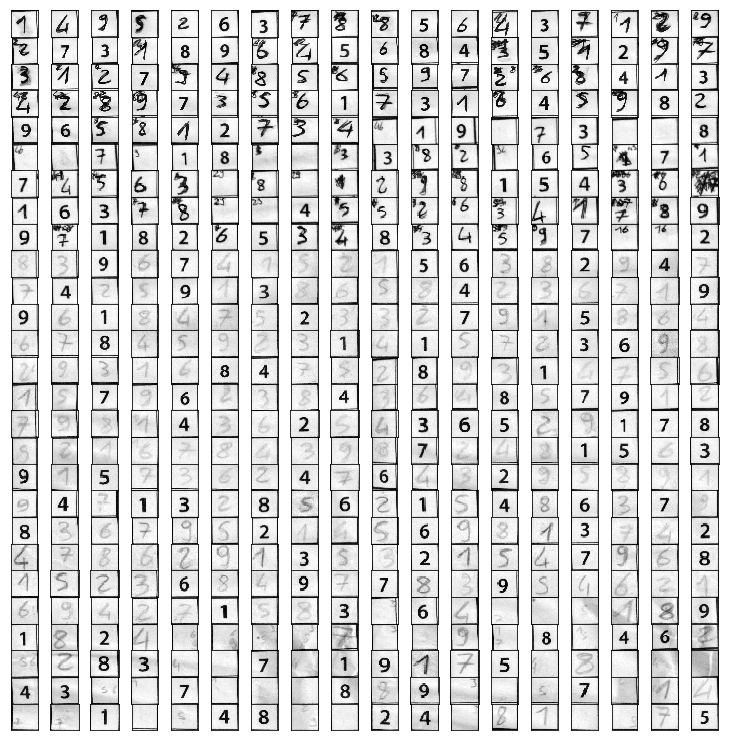

In [7]:
def extract_digit_images(arg):
    # first, extract the digits from each square
    digits = []
    for k, (ax, ay, bx, by) in enumerate(arg['squares']):
        digit_width, digit_height = (bx - ax) / 3, (by - ay) / 3
        for i in range(3):
            for j in range(3):
                px, py = int(ax + j * digit_width), int(ay + i * digit_height)
                qx, qy = int(ax + (j + 1) * digit_width), int(ay + (i + 1) * digit_height)
                
                digit = arg['img'][py:qy, px:qx]
                digits.append({
                    'rect': (px, py, qx, qy),
                    'img': digit,
                })
    
    # then, re-arrange the digits to be row-wise from top to bottom and from left to right
    arg['digits'] = []
    for row in range(9):
        row_in_square = row % 3
        left_square = 3 * (row // 3)
        
        for square in range(3):
            base_idx = (left_square + square) * 9 + 3 * row_in_square
            arg['digits'].extend(digits[base_idx:base_idx+3])
    
    return arg


images_digits = list(map(extract_digit_images, images_all_squares))

plt.figure(figsize=(10, 10))
for i, arg in enumerate(images_digits[:6]):
    for j, digit in enumerate(arg['digits']):
        plt.subplot(9 * 3, 9 * 2, 81 * i + j + 1)
        plt.imshow(digit['img'], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

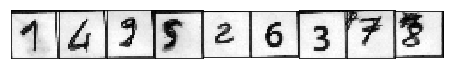

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  149526378


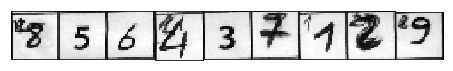

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  856437129


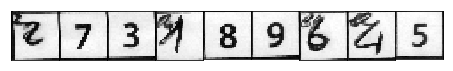

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  273189645


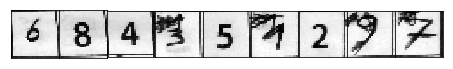

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  684351297


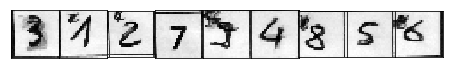

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  312794856


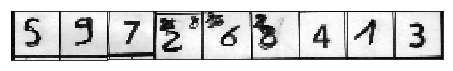

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  597268413


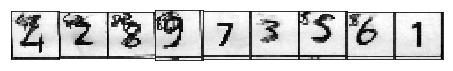

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  428973561


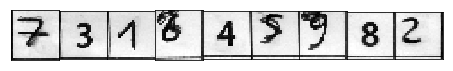

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  731645982


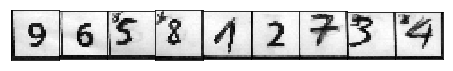

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  965812734


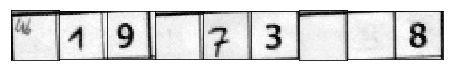

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  .19.73..8


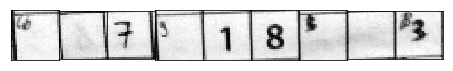

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ..7.18..3


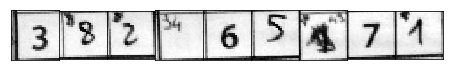

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  382.65171


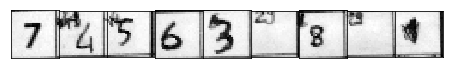

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  74563.8.1


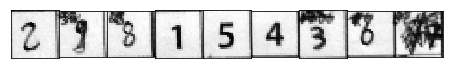

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  298154367


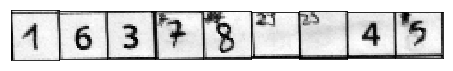

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  16378..45


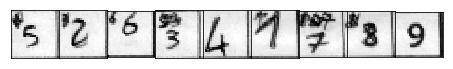

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  526341789


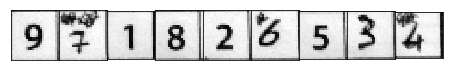

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  971826534


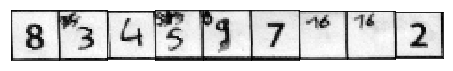

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  834597..2


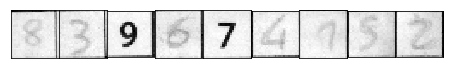

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  839674152


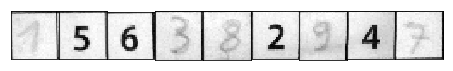

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  156382947


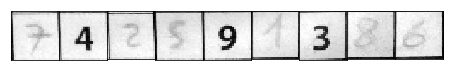

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  742591386


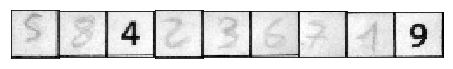

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  584236719


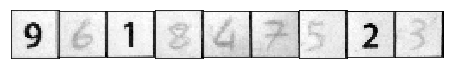

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  961847523


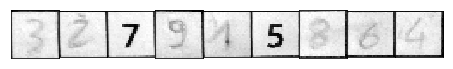

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  327915864


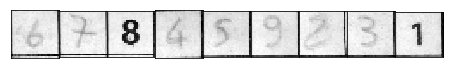

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  678459231


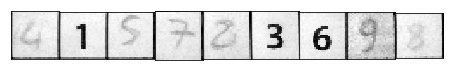

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  415723698


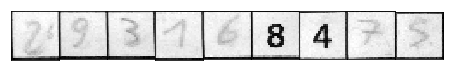

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  293168475


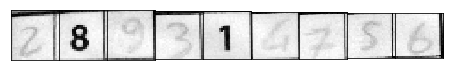

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  289314756


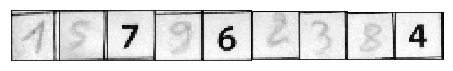

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  157962384


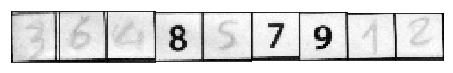

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  364857912


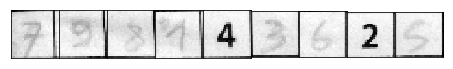

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  798143625


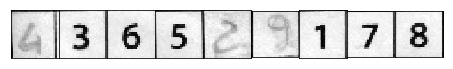

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  436529178


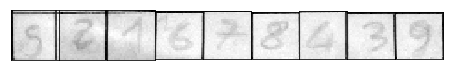

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  521678439


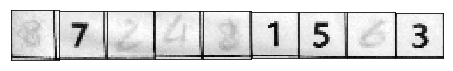

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  872481563


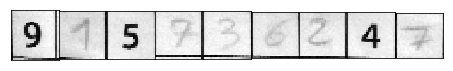

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  915736247


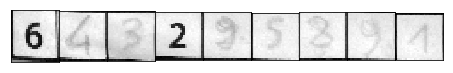

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  643295891


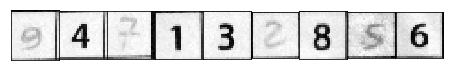

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  947132856


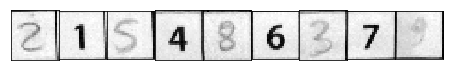

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  215486379


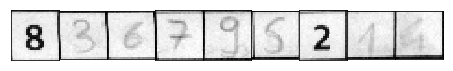

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  836795214


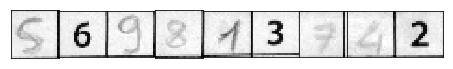

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  56981374
>  569813742


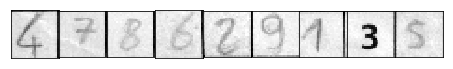

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  478629135


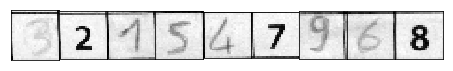

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  321547968


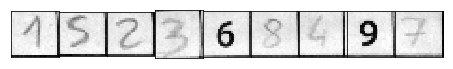

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  152368497


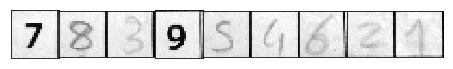

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  783954621


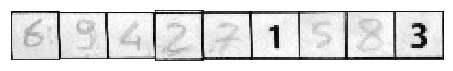

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  694271583


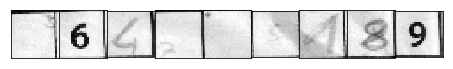

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  .64...189


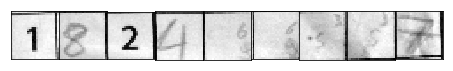

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  1824....7


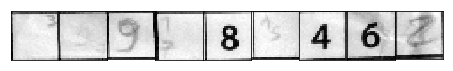

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ..9.8.462


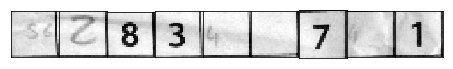

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  .283..7.1


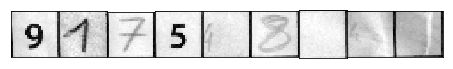

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  9175.8...


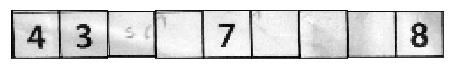

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  43..7...8


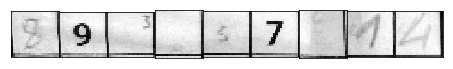

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  89...7.14


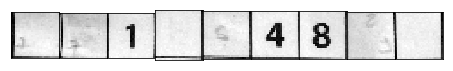

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ..1..48..


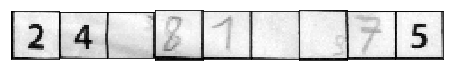

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  24.81..75


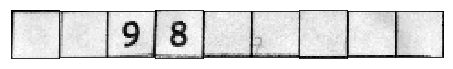

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ..98.....


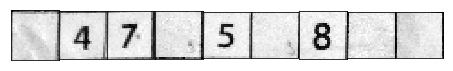

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  .47.5.8..


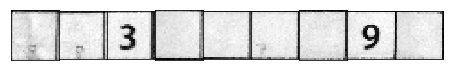

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ..3....9.


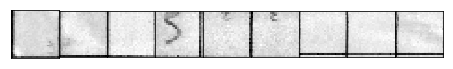

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ...5.....


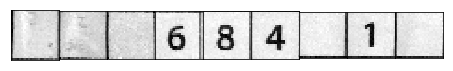

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ...684.1.


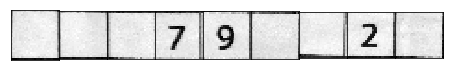

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ...79..2.


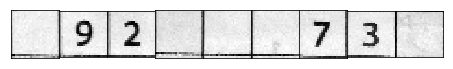

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  .92...73.


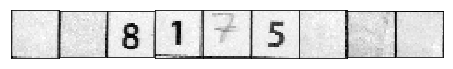

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  ..8175...


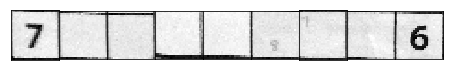

Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.


>  7.......6


In [13]:
for arg in images_digits:
    for i in range(0, 81, 9):
        batch = arg['digits'][i:i+9]
        for j, digit in enumerate(batch):
            plt.subplot(1, 9, j + 1)
            plt.imshow(digit['img'], cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
        plt.show()

        labels = None
        print('Please input 9 labels, row-wise, from top to bottom and left to right, any non-digit for empty cell, or "q" to quit.')
        while not labels or (labels != 'q' and len(labels) != 9):
            labels = input('> ')

        if labels != 'q':
            for lbl, digit in zip(labels, batch):
                digit['label'] = int(lbl) if lbl.isdigit() else None
        else:
            break
    
    if labels == 'q':
        break

In [26]:
dest_dir = './digits/'
with open('labels.json', 'w') as f:
    for arg in images_digits:
        for i, digit in enumerate(arg['digits']):
            digit['fname'] = os.path.split(arg['orig'])[-1].replace('.jpg', '-%d.jpg' % i)
            cv2.imwrite(dest_dir + digit['fname'], digit['img'])
            f.write('%s\n' % json.dumps({
                'label': digit['label'],
                'fname': digit['fname'],
            }))